# Домашнее задание 3

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)
pio.renderers.default = "notebook_connected"

import datetime
from tqdm import tqdm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import kpss
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV, temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import grangercausalitytests
MAE = MeanAbsoluteError()


## Блок 1. Введение

В этом небольшом домашнем задании мы потренируемся работать с SARIMA-моделью. Для начала про данные. В этот раз они недельные. Будем прогнозировать на небольшой горизонт, 4 недели.

* target -- средневзвешенная по портам стоимость аммиака (usd/tonn) в некотором европейском регионе. Аммиак -- один из основных компонентов для производства азотных удобрений.
* oil -- стоимость фьючерса на нефть марки BRENT (usd)
* gas -- стоимость фьючерса на природный газ (usd)
* coal -- стоимость фьючерса на уголь (usd)
* corn, soybean, wheat, rice -- стоимость кукурузы, сои, пшеницы и риса соответственно (usd)

* usd_eur, usd_rub, usd_jpy, usd_cny -- курсы евро, рубля, йены и юаня к доллару
* usd_index -- индекс доллара

* cpy_us, cpi_china -- ВВП США и Китая


### 1.1) Загрузка данных. (0.5 балла)

Загрузите данные из файла data.csv. Сконвертируйте индексы в формат datetime. Обратите внимание на формат даты. При дефолтных параметрах конвертация произойдёт неверно. Далее используйте метод to_period, чтобы сконвертировать индексы, иначе ARIMA упадёт. В этот раз не будем разбивать на трейн и тест, а просто пройдёмся кросс-валидацией по всей выборке.



In [2]:
data = pd.read_csv('data.csv')
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')
data.set_index('date', inplace=True)
data.index = data.index.to_period('W-SUN')

### 1.2) Визуальный анализ. (1 балл)

Изобразите временной ряд, его автокорреляции и частные автокорреляции. Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Стационарность?

*В переменных есть пропущенные значения (не только в начале, но иногда и уже в те моменты, когда данные в целом доступны). Для нормального подсчета ACF и PACF сначала заполним пропуски предыдущим значением, учитывая что их не так много. Остальные NaN'ы в начале датасета отбросим.*

In [3]:
for col in data.columns:
    data[col] = data[col].fillna(method='ffill', limit=4)
    
data.dropna(inplace=True)

assert data.resample('W-SUN').sum().shape == data.shape

In [4]:
fig = px.line(
    data, 
    x=data.index.to_timestamp(), 
    y='target',
    title='Наш временной ряд ❤️'
    )
fig.show()

Построим графики ACF и PACF:

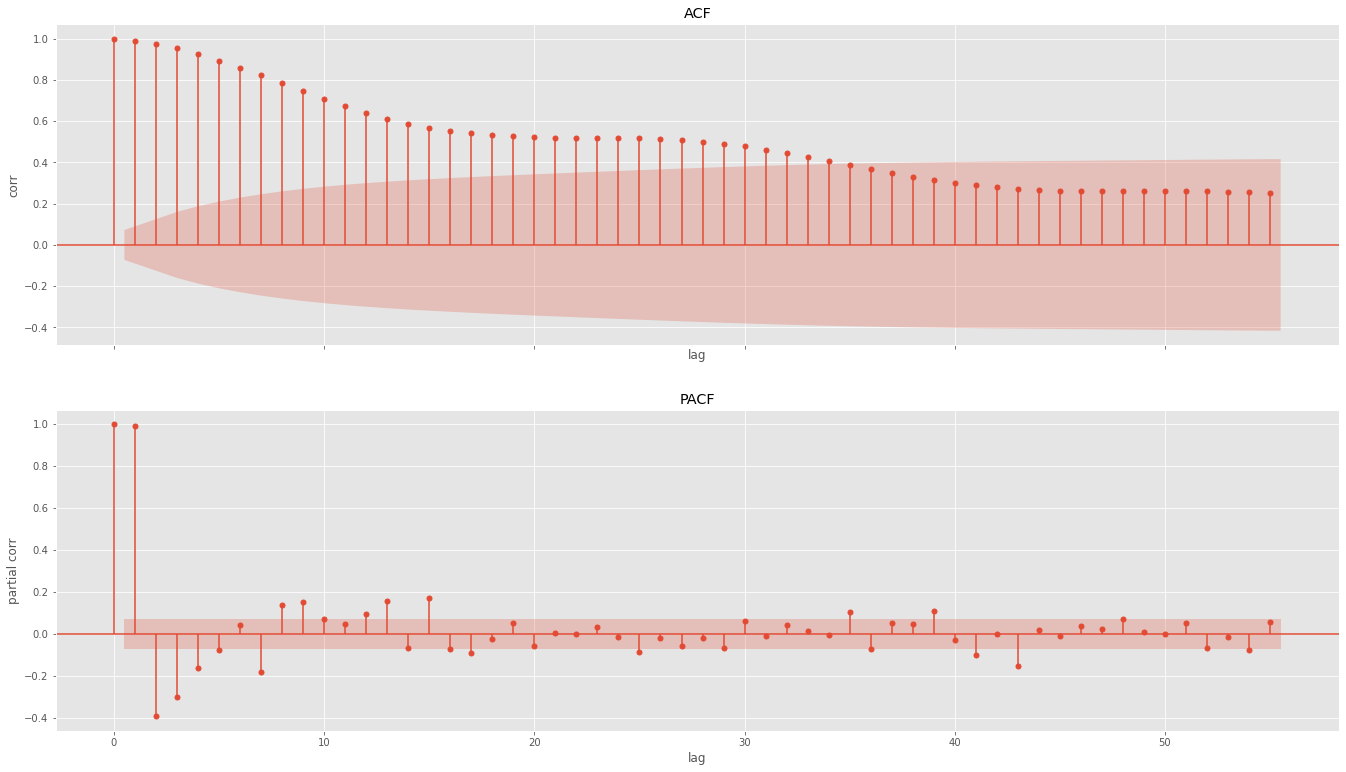

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(23, 13), sharex=True)
plot = plot_acf(data['target'], ax=ax[0], lags=55)
plot = plot_pacf(data['target'], ax=ax[1], lags=55)
ax[0].set(title='ACF', xlabel='lag', ylabel='corr')
ax[1].set(title='PACF', xlabel='lag', ylabel='partial corr')
plt.show()

Ряд в целом довольно безумный. В нем нет выраженного тренда и сезонности. Конечно, он не стационарен. Цикличность углядеть, разумеется, можно &mdash; она скорее всего примерно соответствует цикличности мировой экономики.

## Блок 2. SARIMA

Сначала попробуем прогнозировать без внешних переменных.

### 2.1) Стационарность (1 балл)

Сначала примените сглаживающее преобразование (например, Бока-Кокса, или иное по своему усмотрению), если необходимо. 

Определите параметры d и D. Для этого воспользуйтесь STL-разложением и KPSS-тестом.

Детрендируйте ряд согласно параметрам d и D.

**Сглаживающее преобразование**

Прологарифмируем ряд. Визуально это его особо не изменит, но возможно поможет нам в дальнейшем при переходе к разностям.

In [6]:
def box_cox(x, lbd):
    return (np.power(x, lbd) - 1) / lbd

In [7]:
data['target_log'] = np.log(data['target'])

In [8]:
fig = px.line(
    data, 
    x=data.index.to_timestamp(), 
    y='target_log',
    title='Наш временной ряд с логарифмом ❤️❤️❤️'
    )
fig.show()

**Порядок разности ($\Delta$)**

Сначала визуализируем несколько вариаций ряда: исходный логарифмированный, $\Delta$ и $\Delta^2$.


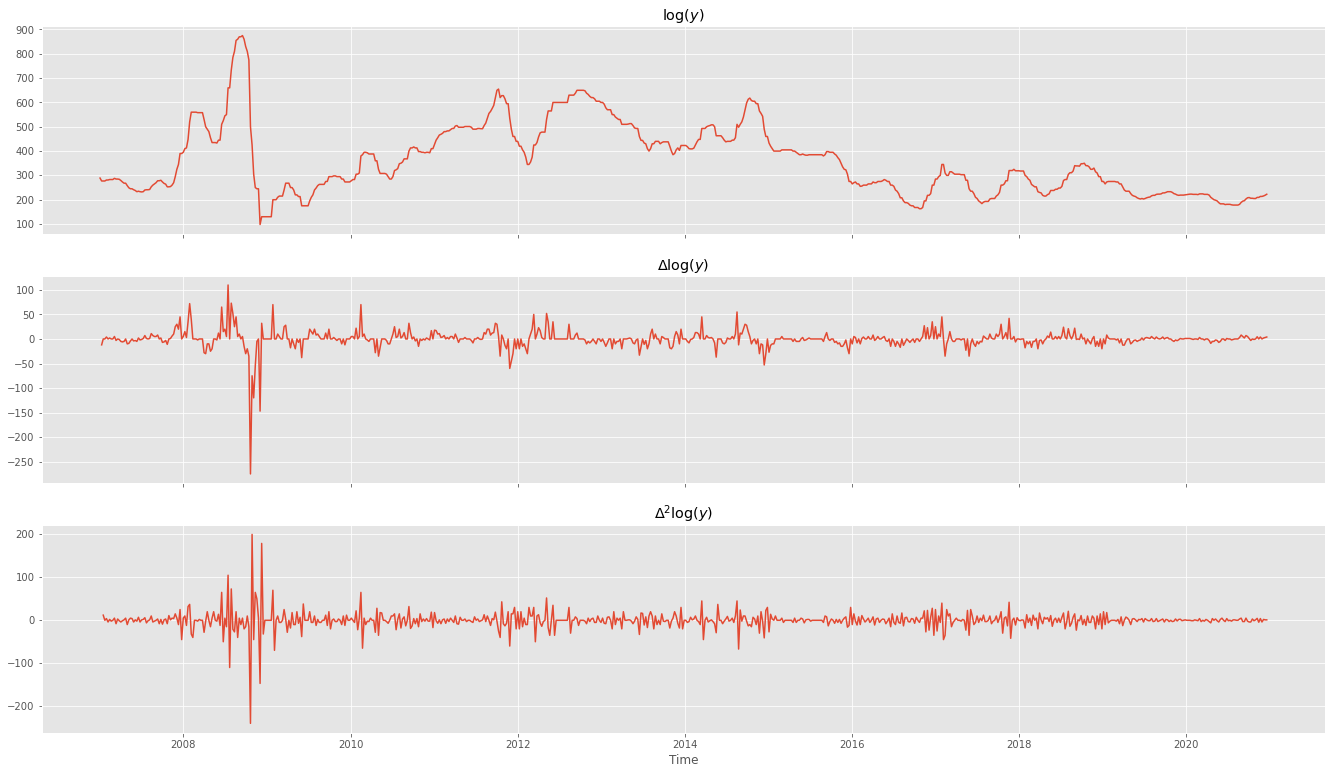

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(23, 13), sharex=True)
plot = ax[0].plot(data.index.to_timestamp(), data['target'])
plot = ax[1].plot(data.index.to_timestamp()[1:], data['target'].diff().dropna())
plot = ax[2].plot(data.index.to_timestamp()[2:], data['target'].diff().diff().dropna())
ax[0].set(title='$\log (y)$', xlabel='', ylabel='')
ax[1].set(title='$\Delta \log (y)$', xlabel='', ylabel='')
ax[2].set(title='$\Delta^2 \log (y)$', xlabel='Time', ylabel='')
plt.show()

Гарчи прилетели, ага. Но мы пока что не помним про их существование и работаем с тем, что есть.

**KPSS тест**

Проведем KPSS-тест для исходного ряда и двух разностей (первой и второй степени).

In [10]:
def KPSS(x):
    stat, p_value, lags, crit = kpss(x)
    verdict = 'H0 отвергается (5%)' if p_value < 0.05 else f'H0 не отвергается (5%)\nkpss_lags = {lags}'
    print(verdict)

In [11]:
KPSS(data['target']) # исходный ряд

H0 отвергается (5%)


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [12]:
KPSS(data['target'].diff().dropna()) # delta^1

H0 не отвергается (5%)
kpss_lags = 20


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [13]:
KPSS(data['target'].diff().diff().dropna()) # delta^2

H0 не отвергается (5%)
kpss_lags = 20


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Таким образом, исходный ряд не стационарный по тренду (как будто кто-то в этом сомневался), а вот обе его разности эту гипотезу не отвергают. Двойные разности мне не нравятся, так что давайте пока остановимся на $\Delta y_t$.

In [14]:
data['target_log_diff'] = data['target_log'].diff()

**STL разложение**


Теперь займемся сезонными разностями, подсчитав силу сезонности через STL-разложение.

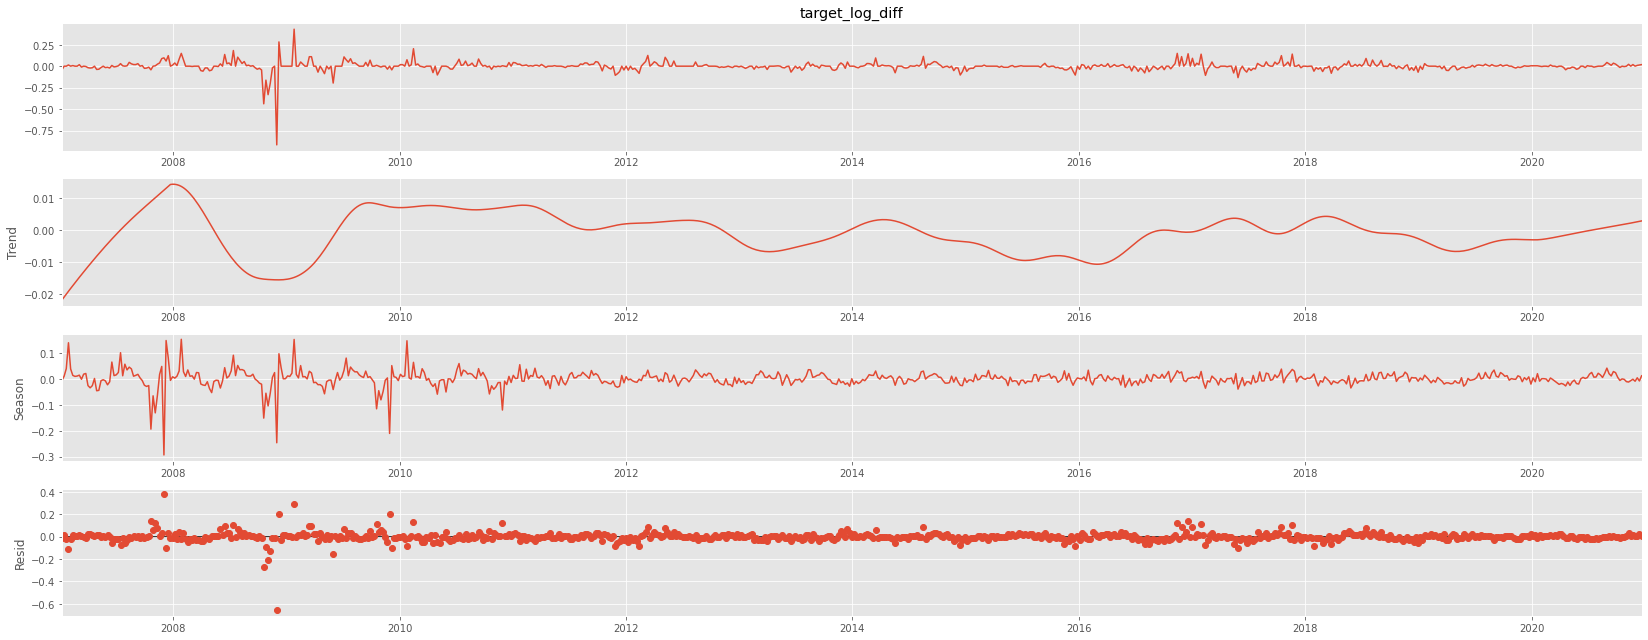

In [15]:
data_stl = data.dropna()
data_stl.index = data_stl.index.to_timestamp()
stl = STL(data_stl['target_log_diff'])
res = stl.fit()
res.plot();

Заметим, что STL подобрал нам период ряда &mdash; 52 недели, то есть примерно год:

In [16]:
stl.period

52

Однако кажется, что это не самый лучший вариант (ниже я объясню, почему), так что посмотрим на STL с `period=26` (полгода).

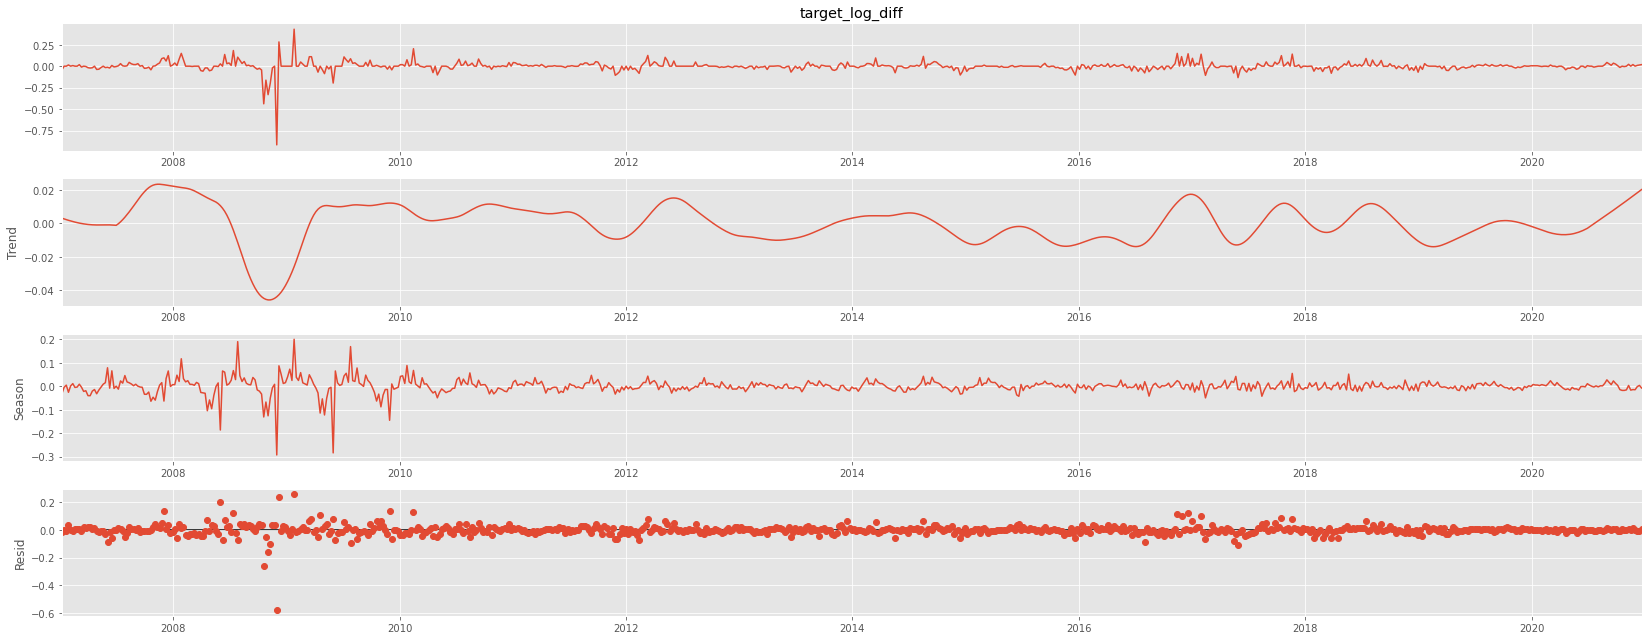

In [17]:
data_stl = data.dropna()
data_stl.index = data_stl.index.to_timestamp()
stl_2 = STL(data_stl['target_log_diff'], period=26)
res_2 = stl_2.fit()
res_2.plot();

Теперь посчитаем силу сезонности для обеих вариаций STL

In [18]:
def seas_strength(resid, seasonal):
    return np.round(max(0, 1 - resid.std()**2 / (resid.std()**2 + seasonal.std()**2)), 3)

In [19]:
seas_strength(res.resid, res.seasonal)

0.316

In [20]:
seas_strength(res_2.resid, res_2.seasonal)

0.383

Эвристика говорит, что сезонность учитывать не нужно вне зависимости от `period`. Однако в силу сложной структуры ряда все же учтем, вдруг она поможет получить хорошие предсказания.

### 2.2) Анализ коррелограмм (1 балл)

Определите период сезонности, если она предполагается. Предположите, в каких границах лежат параметры p, q, P, Q. Для этого используйте коррелограммы.


*Сперва для $p$ и $q$. Границу для AR определяем по PACF, для MA &mdash; по ACF:*

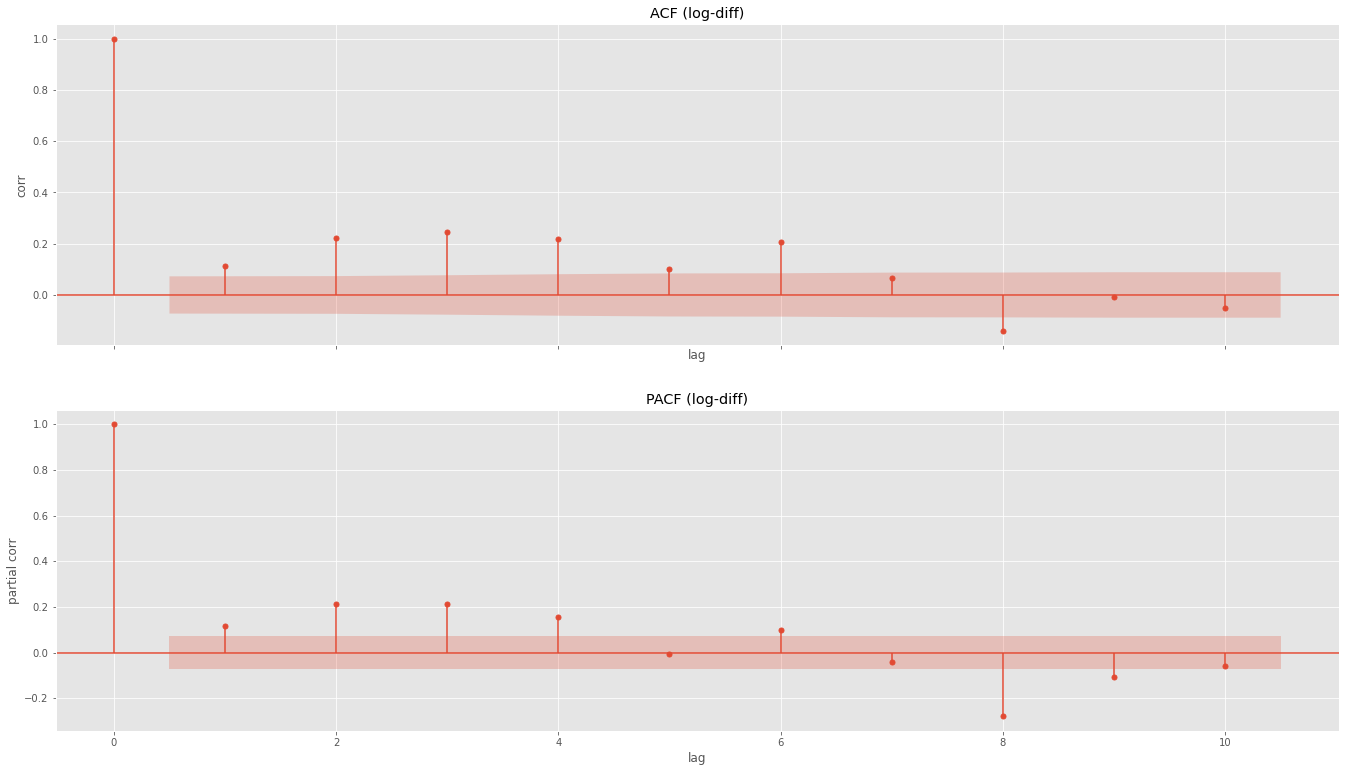

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(23, 13), sharex=True)
plot = plot_acf(data['target_log_diff'].dropna(), ax=ax[0], lags=10)
plot = plot_pacf(data['target_log_diff'].dropna(), ax=ax[1], lags=10)
ax[0].set(title='ACF (log-diff)', xlabel='lag', ylabel='corr')
ax[1].set(title='PACF (log-diff)', xlabel='lag', ylabel='partial corr')
plt.show()

Графики довольно дурацкие, но попробуем подобрать что-то в таком интервале:

In [22]:
p_max = 2
q_max = 2

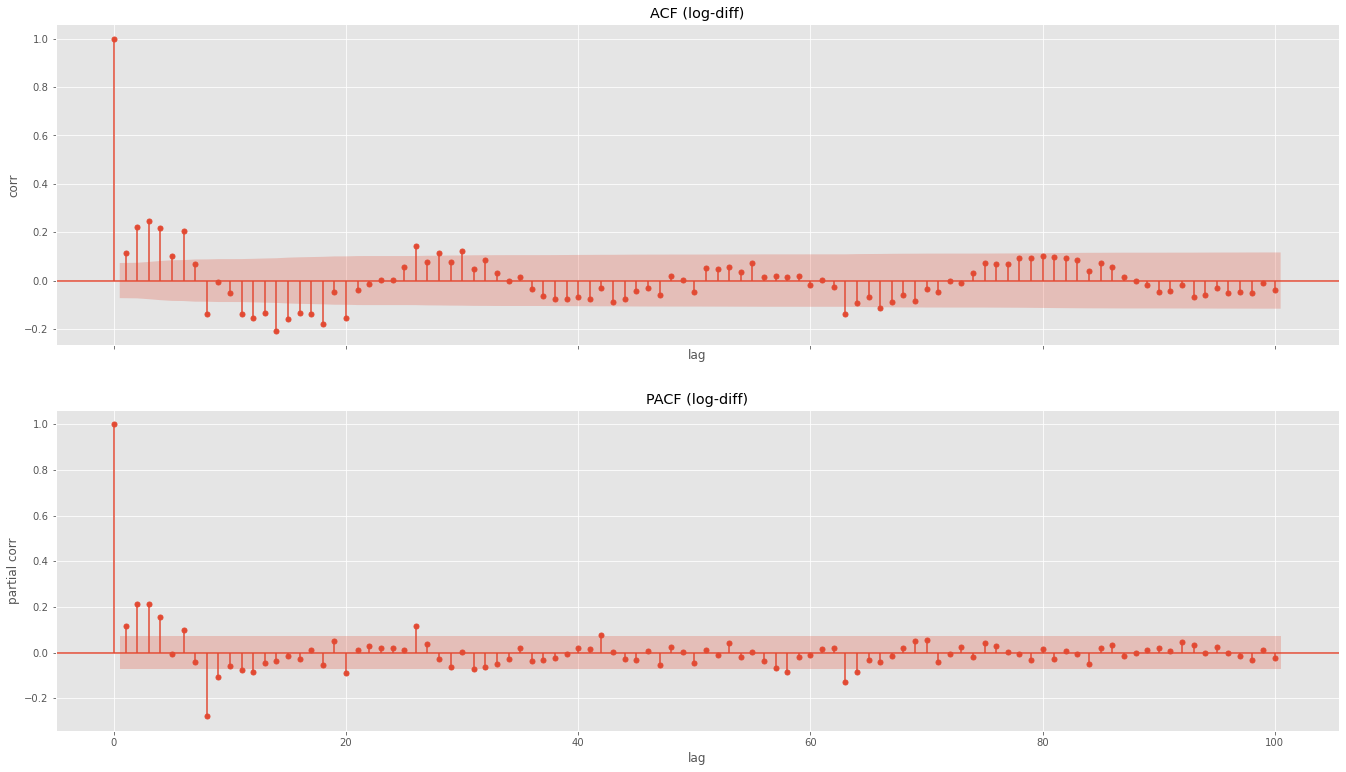

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(23, 13), sharex=True)
plot = plot_acf(data['target_log_diff'].dropna(), ax=ax[0], lags=100)
plot = plot_pacf(data['target_log_diff'].dropna(), ax=ax[1], lags=100)
ax[0].set(title='ACF (log-diff)', xlabel='lag', ylabel='corr')
ax[1].set(title='PACF (log-diff)', xlabel='lag', ylabel='partial corr')
plt.show()

Тут я был ограничен производительностью кросс-валидации. Пришлось максимально сжать множество значений P и Q:

In [24]:
P_max = 1
Q_max = 1

С сезонностью, конечно, сложно. С одной стороны, 52 периода (примерно год) &mdash; довольно логичный выбор. Но тогда мы сильно повышаем требования к количеству данных, да и графики ACF и PACF тут не указывают в сторону сильной автокорреляции. Можно увидеть сильную отрицательную PACF в восьмом периоде (~2 месяца) и 26 периоде (полгода). Короче, давайте остановимся на 26: тут и логика есть, и PACF выбивается, и сила сезонности из STL разложения была выше.

In [25]:
d = 1
D = 0
sp = 26

### 2.3) Кросс-валидация (0.5 балла)

Сгенерируйте сетку параметров. Отберите на кросс-валидации наилучшую модель. Используйте метод скользящего окна. Ширина окна 150 (~3 года). Шаг -- 4 недели. Если получается слишком долго, возьмите шаг побольше, 10-15. Длина тестового периода -- 4 недели. Метрика -- MAE.

In [26]:
orders = []

for p in range(p_max+1):
    for q in range(q_max+1):
        orders.append((p, d, q))

seasonal_orders = []

for p in range(P_max+1):
    for q in range(Q_max+1):
        seasonal_orders.append((p, D, q, sp))

In [27]:
cv = SlidingWindowSplitter(fh=[1,2,3,4], window_length=150, step_length=15)
forecaster = ARIMA()
param_grid = {"order" : orders, "seasonal_order" : seasonal_orders}
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    scoring=MAE,
    cv=cv, n_jobs=-1)

gscv.fit(data['target_log'].dropna())

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmo

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=[1, 2, 3, 4], step_length=15, window_length=150),
                        forecaster=ARIMA(), n_jobs=-1,
                        param_grid={'order': [(0, 1, 0), (0, 1, 1), (0, 1, 2),
                                              (1, 1, 0), (1, 1, 1), (1, 1, 2),
                                              (2, 1, 0), (2, 1, 1), (2, 1, 2)],
                                    'seasonal_order': [(0, 0, 0, 26),
                                                       (0, 0, 1, 26),
                                                       (1, 0, 0, 26),
                                                       (1, 0, 1, 26)]},
                        scoring=MeanAbsoluteError())

Посмотрим на лучшую модель:

In [28]:
gscv.best_forecaster_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  730
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 26)   Log Likelihood                1060.827
Date:                              Fri, 08 Apr 2022   AIC                          -2111.653
Time:                                      18:19:52   BIC                          -2088.695
Sample:                                           0   HQIC                         -2102.795
                                              - 730                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.001     -0.088      0.930      -0.003       0.003
ar.L1          0.0957      0.010      9.635      0.000       0.076       0.115
ar.S.L26       0.5668      0.240      2.366      0.018       0.097       1.036
ma.S.L26      -0.4554      0.255     -1.787      0.074      -0.955       0.044
sigma2         0.0032   2.85e-05    111.778      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):            363910.96
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -5.70
Prob(H) (two-sided):                  0.00   Kurtosis:                       111.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
gscv.best_score_

0.03595319850795789

Быстренько нарисую что получилось у лучшей модели:

<AxesSubplot:xlabel='date'>

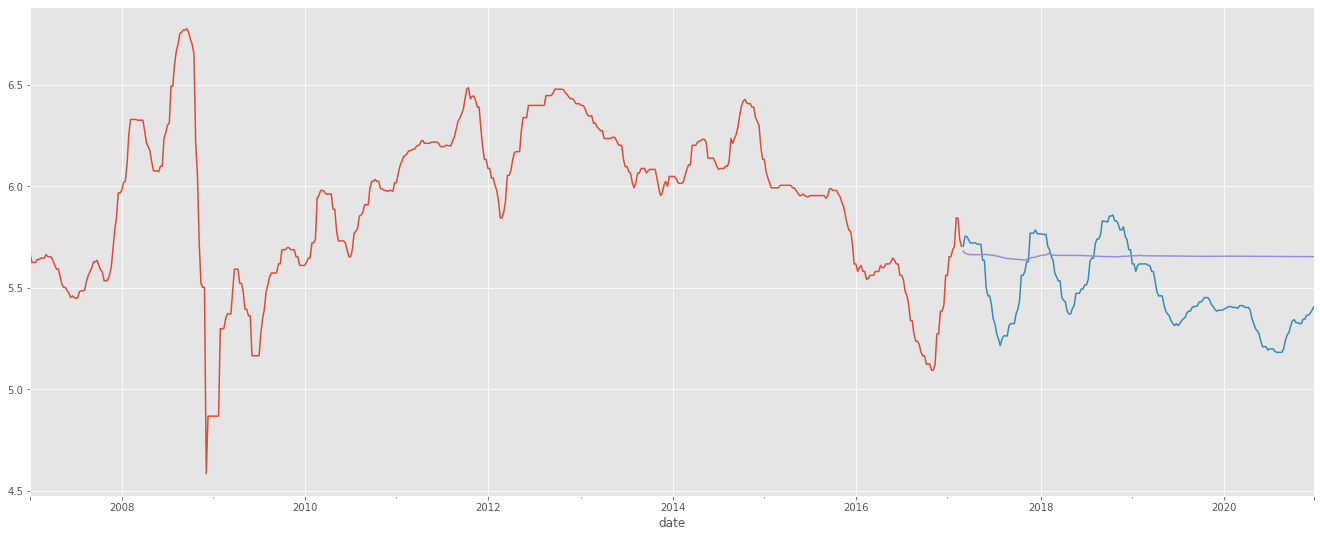

In [30]:
train = data['target_log'].iloc[:-200]
test = data['target_log'].iloc[-200:]
test_idx = test.index

pred = ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 1, 26)).fit(train).predict(ForecastingHorizon(test_idx, is_relative=False))

train.plot()
test.plot()
pred.plot()

### 2.4 Сравнение (0.5 балла)

Сравните ошибку на кросс-валидации для вашей модели, наивной модели и AutoARIMA. Не забудьте проверить, что границы поиска параметров AutoARIMA не меньше ваших. Получилось ли переиграть две последние модели? Совпали ли отобранная вами модель и модель из AutoARIMA?


In [31]:
naive_maes = []
auto_maes = []

for i, j in SlidingWindowSplitter(fh=[1,2,3,4], window_length=150, step_length=15).split(data['target_log']):
    train = data['target_log'].iloc[i]
    test = data['target_log'].iloc[j]
    naive = [data['target_log'].iloc[i[-1]]] * len(j)
    MAE_naive = MAE(test, naive)
    naive_maes.append(MAE_naive)

    autoar = AutoARIMA(max_p=p_max+2, max_q=q_max+2, max_P=P_max+1, max_Q=Q_max+1, sp=26)
    autoar.fit(train)
    autoar = autoar.predict(fh=ForecastingHorizon([1,2,3,4], is_relative=True))
    MAE_auto = MAE(test, autoar)
    auto_maes.append(MAE_auto)

MAE_naive = np.round(np.mean(naive_maes), 4)
MAE_auto = np.round(np.mean(auto_maes), 4)

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelih

Ошибка в нашей ариме была 0.03595319850795789

Получается, наша модель оказалась чуточку лучше, чем авто-арима! 

In [32]:
print('MAE наивной модели: ', MAE_naive, '\nMAE AutoARIMA: ', MAE_auto, sep='')

MAE наивной модели: 0.0408
MAE AutoARIMA: 0.0377


## Блок 3. SARIMAX

Маленькое вступление. Теперь мы попытаемся добавить в модель внешние регрессоры. Вообще говоря, модель SARIMAX -- это попытка объединить в одной модели всё сразу, что, ожидаемо, редко приводит к хорошему и устойчивому результату. И, что самое главное, такую модель ещё сложнее настраивать. Более эффективным с практической точки зрения было бы построить отдельно модель на внешних переменных (в духе моделей машинного обучения), а с автокорреляциями в её остатках побороться уже SARMA-моделью, но в случае линейной регрессии особой разницы не будет.  Но мы всё же разберём этот подход, чтобы понимать его сложности.

Если коротко про достоинства и недостатки этой модели:

Плюсы:

* Весьма гибкая модель, позволяет учесть кучу особенностей в данных
* Может быть неплоха, если нам нужны только одношаговые прогнозы и у нас не очень много переменных

Минусы:

* Ещё сложнее настраивать, чем SARIMA
* Рекурсивна. Отсюда проблемы с многошаговым прогнозированием и накоплением ошибки
* При большом количестве экзогенных переменных и малом числе наблюдений может быть неустойчива

### 3.1) Выбор внешней переменной (1 балл)

Из всех внешних факторов выберите какую-нибудь переменную, которая будет удовлетворять тесту Гранжера. Кратко опишите причинно-следственную связь, которая может возникать между этими переменными. 

По дефолту в следующих пунктах в качестве фичи можете использовать первый лаг отобранной переменной. Если захотите взять ещё лаги, это конечно хорошо, но придётся аккуратно разбираться с прогнозом каждого лага, поэтому предлагается не усложнять себе жизнь.

*В качестве экзогенной переменной возьмем стоимость соевых бобов, предполагая, что их высокая стоимость приведет к повышенному спросу на удобрения, используемые в сельском хозяйстве. При этом возьмем ее с большим лагом (4 недели), поскольку кажется, что реакция рынка удобрений не должна быть особо быстрой. К тому же, это позволит не париться с отдельной моделью для X при предсказании на 4 шага. Хе-хе*

In [33]:
data['soybean_lag'] = data.soybean.shift(4)

Гипотеза о том, что что временной ряд `soybean_lag` НЕ помогает в прогнозировании ряда `target`, **отвергается**.

In [34]:
columns = data.dropna().loc[:,('target','soybean_lag')]
_= grangercausalitytests(columns, maxlag = [10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.5211  , p=0.0000  , df_denom=695, df_num=10
ssr based chi2 test:   chi2=56.8794 , p=0.0000  , df=10
likelihood ratio test: chi2=54.7331 , p=0.0000  , df=10
parameter F test:         F=5.5211  , p=0.0000  , df_denom=695, df_num=10


### 3.2) Фильтрация (1.5 балла)

Использование внешней переменной несколько осложняет подбор параметров SARIMA. Дело в том, что если ряды y и x одинакового порядка интеграции, то при использовании их в одном уравнении тренды могут взаимно сократиться:

$$ y_t = SARIMA + \alpha_1 x_{t-1}$$

$$ y_t - \alpha_1 x_{t-1} = SARIMA $$

При некоторых обстоятельствах разница  $ y_t - \alpha_1 x_{t-1} $ может дать стациионарный ряд. В литературе такая ситуация называется коинтеграцией. Есть много не слишком внятных статей на эту тематику. Особенно туманны выводы для случаев, когда коинтеграции нет. Но в целом всё это скорее разговор о теоретических характеристиках оценок коэффициентов моделей. В контексте прогнозирования это обычно не учитывают и каких-то внятных рекомендаций тоже нет, либо они не распространены. Поэтому единственный адекватный способ узнать это влияние -- построить регрессию (либо SARIMA((0,0,0), (0,0,0)) с экзогенной переменной), а потом посмотреть, как устроены остатки, и на основе них сделать выводы о параметрах SARIMA. 

В большинстве случаев люди, конечно, так не заморачиваются. Берут AutoARIMA либо достаточно широкие границы на кросс-валидации и просто ждут. Но мы же учёные, нам так неинтересно!

Здесь уже видно, что в таком виде SARIMAX-модель банально аналогична тому, что мы оцениваем две модели: линрег, а на его остатки навешиваем SARIMA. Единственный плюс в том, что мы сможем это объединить в одном уравнении.


Собственно, задание: постройте SARIMAX((0,0,0), (0,0,0))  с выбранной экзогенной переменной (либо просто линрег y_t на x_{t-1}, будет то же самое). Будьте внимательны, дефолтный параметры класса ARIMA -- не совсем то, что мы просим. Далее получите остатки на трейне этой одношаговой модели.

In [35]:
data_arimax = data.dropna()

In [36]:
lr = LinearRegression()
lr.fit(data_arimax[['soybean_lag']], data_arimax['target_log'])

exog_linear = lr.predict(data_arimax[['soybean_lag']])
data_arimax['exog_linear'] = exog_linear
data_arimax['resid_linear'] = data_arimax['target_log'] - data_arimax['exog_linear']

In [37]:
fig = px.line(
    data_arimax, 
    x=data_arimax.index.to_timestamp(), 
    y=['target', 'soybean_lag'],
    title='X и Y'
    )
fig.show()

In [38]:
fig = px.line(
    data_arimax, 
    x=data_arimax.index.to_timestamp(), 
    y='resid_linear',
    title='Остаток'
    )
fig.show()

In [39]:
fig = px.line(
    data_arimax.diff().dropna(), 
    x=data_arimax.index[1:].to_timestamp(), 
    y='resid_linear',
    title='delta(Остаток)'
    )
fig.show()

### 3.3) Анализ остатков (1 балл)

Остатки из предыдущего пункта -- это по сути y, фильтрованный относительно выбранной экзогенной переменной. Сделайте выводы относительно параметров d и D, а также относительно границ параметров p, q, P, Q.

In [40]:
KPSS(data_arimax['resid_linear']) # исходный ряд
KPSS(data_arimax['resid_linear'].diff().dropna()) # delta^1
KPSS(data_arimax['resid_linear'].diff().diff().dropna()) # delta^2

H0 не отвергается (5%)
kpss_lags = 20
H0 не отвергается (5%)
kpss_lags = 20
H0 не отвергается (5%)
kpss_lags = 20


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




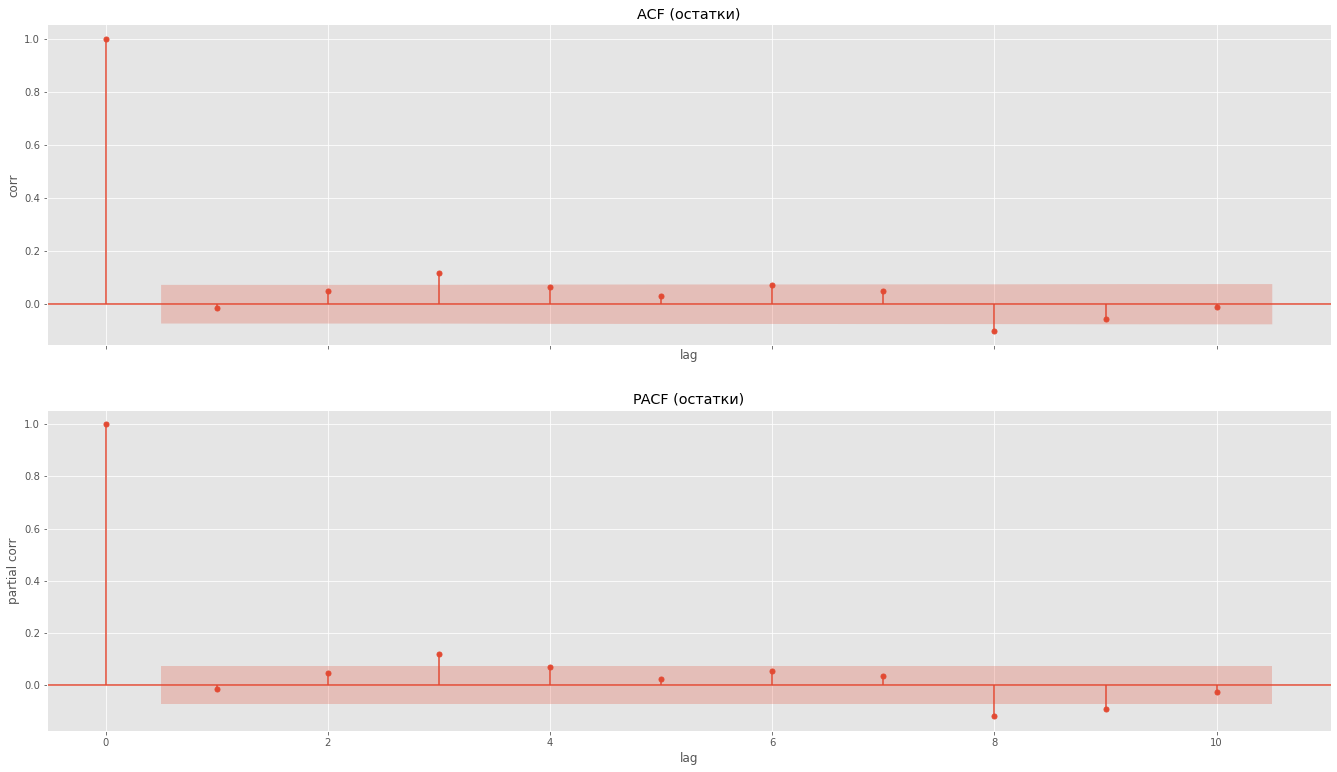

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(23, 13), sharex=True)
plot = plot_acf(data_arimax['resid_linear'].diff().dropna(), ax=ax[0], lags=10)
plot = plot_pacf(data_arimax['resid_linear'].diff().dropna(), ax=ax[1], lags=10)
ax[0].set(title='ACF (остатки)', xlabel='lag', ylabel='corr')
ax[1].set(title='PACF (остатки)', xlabel='lag', ylabel='partial corr')
plt.show()

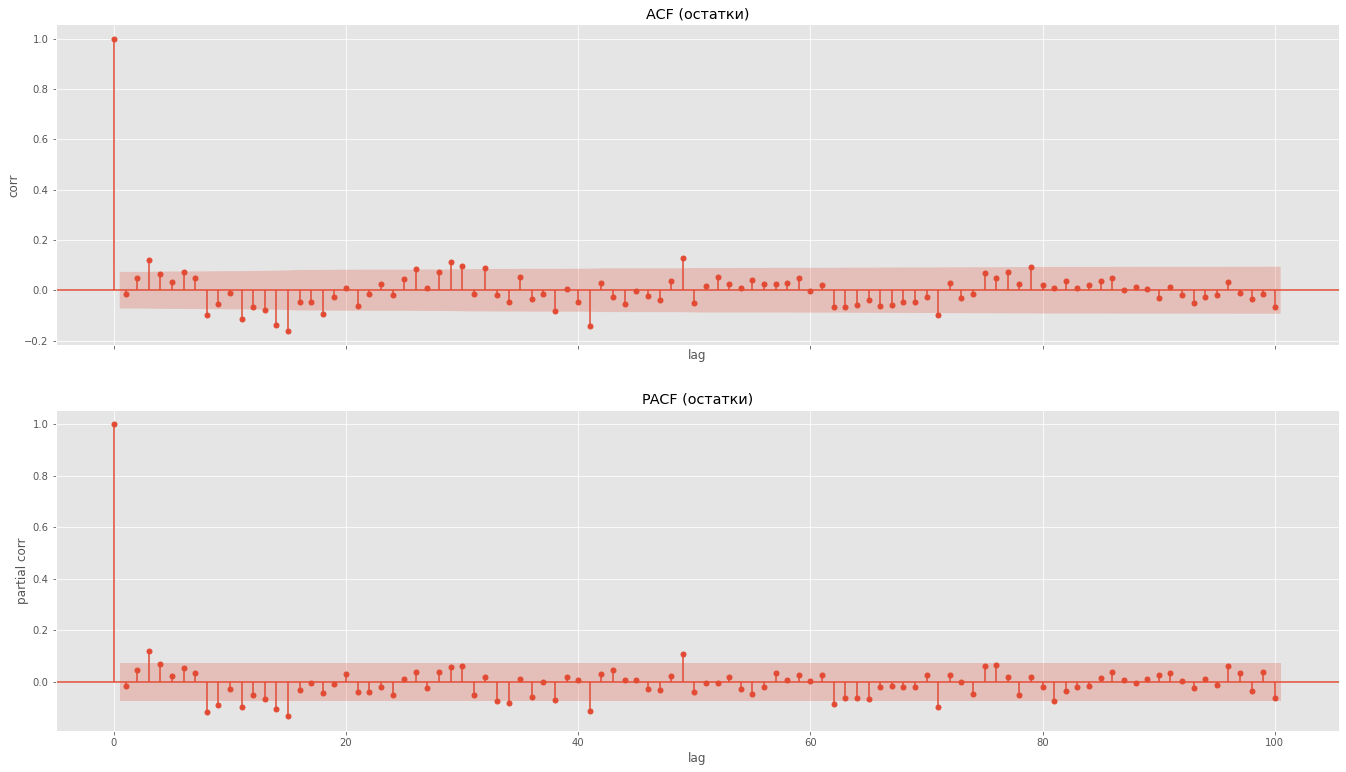

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(23, 13), sharex=True)
plot = plot_acf(data_arimax['resid_linear'].diff().dropna(), ax=ax[0], lags=100)
plot = plot_pacf(data_arimax['resid_linear'].diff().dropna(), ax=ax[1], lags=100)
ax[0].set(title='ACF (остатки)', xlabel='lag', ylabel='corr')
ax[1].set(title='PACF (остатки)', xlabel='lag', ylabel='partial corr')
plt.show()

### 3.4) Кросс-валидация (1.5 балла)

Отберите на кросс-валидации наилучшую модель. Для прогноза фичи на необходимые 4 шага используйте AutoARIMA. 

*Воспользуюсь саримаксом из пакета и запихну его в кросс-валидацию :) Ведь у меня четвертый лаг экзогенной переменной!*



In [43]:
cv = SlidingWindowSplitter(fh=[1,2,3,4], window_length=150, step_length=15)
forecaster = ARIMA(sarimax_kwargs={'time_varying_regression' : False, 'mle_regression' : True})
param_grid = {"order" : orders, "seasonal_order" : seasonal_orders}
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    scoring=MAE,
    cv=cv, n_jobs=-1)

gscv.fit(data_arimax['target_log'], X=data_arimax[['soybean_lag']])

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmo

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=[1, 2, 3, 4], step_length=15, window_length=150),
                        forecaster=ARIMA(), n_jobs=-1,
                        param_grid={'order': [(0, 1, 0), (0, 1, 1), (0, 1, 2),
                                              (1, 1, 0), (1, 1, 1), (1, 1, 2),
                                              (2, 1, 0), (2, 1, 1), (2, 1, 2)],
                                    'seasonal_order': [(0, 0, 0, 26),
                                                       (0, 0, 1, 26),
                                                       (1, 0, 0, 26),
                                                       (1, 0, 1, 26)]},
                        scoring=MeanAbsoluteError())

In [44]:
gscv.best_forecaster_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  726
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 26)   Log Likelihood                1052.491
Date:                            Fri, 08 Apr 2022   AIC                          -2090.982
Time:                                    18:38:06   BIC                          -2058.879
Sample:                                02-04-2007   HQIC                         -2078.593
                                     - 12-27-2020                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -0.0002      0.002     -0.099      0.921      -0.005       0.004
soybean_lag   3.07e-06      0.000      0.017      0.986      -0.000       0.000
ar.L1           0.0447      0.353      0.127      0.899      -0.647       0.737
ma.L1           0.0446      0.353      0.126      0.900      -0.647       0.736
ar.S.L26        0.3594      0.296      1.213      0.225      -0.221       0.940
ma.S.L26       -0.2445      0.310     -0.788      0.431      -0.853       0.364
sigma2          0.0032   3.01e-05    106.415      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):            351703.01
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -5.66
Prob(H) (two-sided):                  0.00   Kurtosis:                       110.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
gscv.best_score_

0.032198938981624924

Визуализируем (тут просто для красоты и простоты предполагаем X известным всегда)!

<AxesSubplot:>

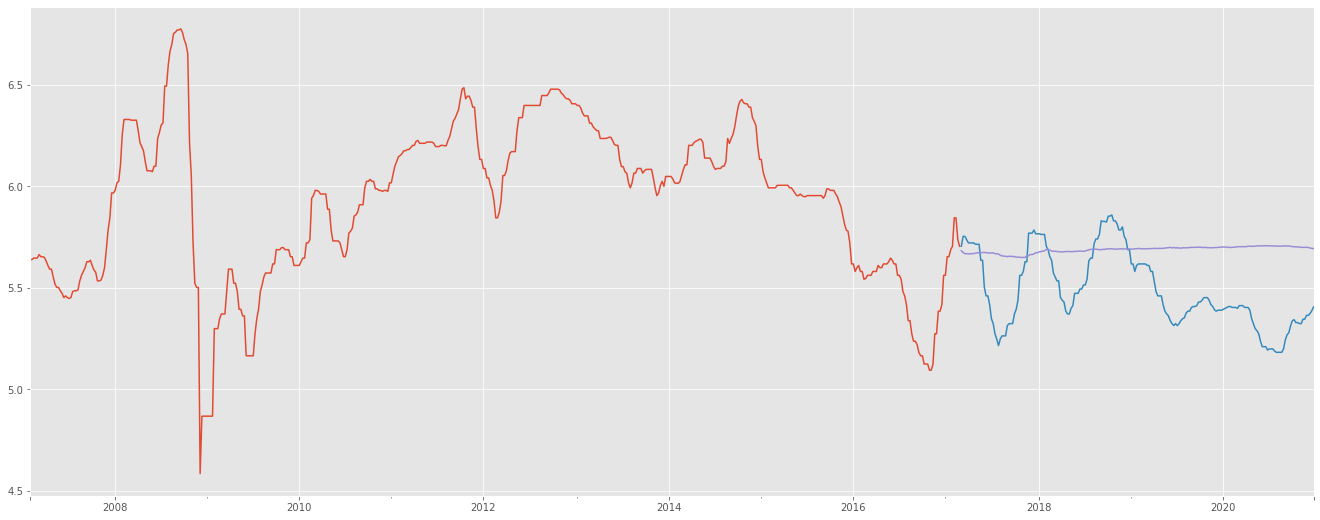

In [46]:
train = data_arimax['target_log'].iloc[:-200]
X_train = data_arimax['soybean_lag'].iloc[:-200]
test = data_arimax['target_log'].iloc[-200:]
X_test = data_arimax['soybean_lag'].iloc[-200:]
test_idx = test.index

pred = ARIMA(
    order=(1, 1, 1), 
    seasonal_order=(1, 0, 1, 26),
    sarimax_kwargs={'time_varying_regression' : False, 'mle_regression' : True}
    ).fit(train, X=X_train).predict(ForecastingHorizon(test_idx, is_relative=False), X=X_test)

train.plot()
test.plot()
pred.plot()

### 3.5) Сравнение результатов (0.5 балла)

Добавьте к сравнению из пункта 2.4 лучшую модель из пункта 3.4. Получилось ли лучше?

- SARIMA: 0.03595319850795789
- SARIMAX: 0.032198938981624924

Вышло чуточку лучше :)

In [47]:
# Получилось лучше.

## Скиньте мем (Бесценно)

Можно скидывать прямо в энитаск, в ноутбуках не всегда прикрепляются =(

In [48]:
# ༼ つ ◕_◕ ༽つ

##### Рубрика "как вам домашка?"

Я очень устал